# Import libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')
import json
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras import Sequential
from keras.layers import Dense
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasClassifier
from joblib import dump, load 
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline

# 1. Load Data

In [4]:
#read in samples in JSON/dictionary format one by one,  append each one to a list 
dict_list=[]
with open('transactions.txt', encoding='utf-8') as file:
    for sample in file:
        dict_list.append(json.loads(sample))
        
#Creating dataframe from list of dictionary object.        
transactions_data = pd.DataFrame.from_dict(dict_list, orient='columns')

In [10]:
print('The number of records: ', transactions_data.shape[0])
print('The number of columns: ', transactions_data.shape[1])

The number of records:  641914
The number of columns:  29


In [11]:
transactions_data.columns

Index(['accountNumber', 'customerId', 'creditLimit', 'availableMoney',
       'transactionDateTime', 'transactionAmount', 'merchantName',
       'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'isFraud', 'echoBuffer', 'currentBalance',
       'merchantCity', 'merchantState', 'merchantZip', 'cardPresent',
       'posOnPremises', 'recurringAuthInd', 'expirationDateKeyInMatch'],
      dtype='object')

In [12]:
transactions_data.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,isFraud,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch
0,733493772,733493772,5000.0,5000.00,2016-01-08T19:04:50,111.33,Lyft,US,US,05,...,True,,0.00,,,,False,,,False
1,733493772,733493772,5000.0,4888.67,2016-01-09T22:32:39,24.75,Uber,US,US,09,...,False,,111.33,,,,False,,,False
2,733493772,733493772,5000.0,4863.92,2016-01-11T13:36:55,187.40,Lyft,US,US,05,...,False,,136.08,,,,False,,,False
3,733493772,733493772,5000.0,4676.52,2016-01-11T22:47:46,227.34,Lyft,US,US,02,...,True,,323.48,,,,False,,,False
4,733493772,733493772,5000.0,4449.18,2016-01-16T01:41:11,0.00,Lyft,US,US,02,...,False,,550.82,,,,False,,,False


In [13]:
# check variables types
print(transactions_data.dtypes)

accountNumber                object
customerId                   object
creditLimit                 float64
availableMoney              float64
transactionDateTime          object
transactionAmount           float64
merchantName                 object
acqCountry                   object
merchantCountryCode          object
posEntryMode                 object
posConditionCode             object
merchantCategoryCode         object
currentExpDate               object
accountOpenDate              object
dateOfLastAddressChange      object
cardCVV                      object
enteredCVV                   object
cardLast4Digits              object
transactionType              object
isFraud                        bool
echoBuffer                   object
currentBalance              float64
merchantCity                 object
merchantState                object
merchantZip                  object
cardPresent                    bool
posOnPremises                object
recurringAuthInd            

In [14]:
transactions_data.describe(include=[np.number])

,creditLimit,availableMoney,transactionAmount,currentBalance
count,641914.000000,641914.000000,641914.000000,641914.000000
mean,10697.210608,6652.828573,135.162497,4044.382035
std,11460.359133,9227.132275,147.053302,5945.510224
min,250.000000,-1244.930000,0.000000,0.000000
25%,5000.000000,1114.970000,32.320000,502.442500
50%,7500.000000,3578.165000,85.800000,2151.860000
75%,15000.000000,8169.185000,189.030000,5005.890000
max,50000.000000,50000.000000,1825.250000,47496.500000


In [15]:
transactions_data.describe(include=[np.object])

,accountNumber,customerId,transactionDateTime,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,...,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,merchantCity,merchantState,merchantZip,posOnPremises,recurringAuthInd
count,641914,641914,641914,641914,641914,641914,641914,641914,641914,641914,...,641914,641914,641914,641914,641914,641914,641914,641914,641914,641914
unique,5000,5000,635472,2493,5,5,6,4,19,165,...,899,980,5134,4,1,1,1,1,1,1
top,318001076,318001076,2016-12-25T20:18:11,Lyft,US,US,05,01,online_retail,05/2026,...,633,633,1789,PURCHASE,,,,,,
freq,10034,10034,3,25311,632303,635577,255615,514144,161469,4209,...,11354,11254,10034,608685,641914,641914,641914,641914,641914,641914


In [16]:
transactions_data.describe(exclude=[np.object, np.number])

,isFraud,cardPresent,expirationDateKeyInMatch
count,641914,641914,641914
unique,2,2,2
top,False,False,False
freq,630612,340453,640945


In [19]:
# check missing values
transactions_data.columns[transactions_data.isnull().any()]
# there is no null values

Index([], dtype='object')

In [23]:
# drop duplicates if any
rows_original = transactions_data.shape[0] 
print('Before dropping duplicates, the shape is {}'.format(transactions_data.shape))
transactions_data = transactions_data.drop_duplicates()
print('After dropping duplicates, the shape is {}'.format(transactions_data.shape))
print('There are total {} rows dropped'.format(transactions_data.shape[0] - rows_original))

Before dropping duplicates, the shape is (641914, 29)
After dropping duplicates, the shape is (641914, 29)
There are total 0 rows dropped


## Variables Study

In [24]:
data_df = transactions_data.copy()

In [25]:
def target_info(target_column):
    '''
    Print target column information -- count for each unique values in target column
    Input: target column in dataframe
    '''
    print('There are total {} transactions in our data.'.format(len(target_column)))
    print('Is Fraud:')
    print('Count: {}'.format(sum(target_column == True)))
    print('Proportion: {}'.format(str(round(sum(target_column == True) / len(target_column), 4) * 100) 
                                  + '%'))
    print('Not Fraud:')
    print('Count: {}'.format(sum(target_column == False)))
    print('Proportion: {}'.format(str(round(sum(target_column == False) / len(target_column), 4) * 100)  
                                  + '%'))
    plt.figure(figsize=(5, 5))
    sns.barplot(x=target_column.value_counts().index, y=target_column.value_counts())
    plt.title('Not Fraud vs Is Fraud')
    plt.ylabel('Count')

In [26]:
def categorical_info(df_column):
    '''
    Print categorical variable information -- count for each unique values in target column
    Input: categorical variable column in dataframe
    '''
    print('The number of unique values: {}'.format(len(df_column.unique())))
    print('Categories:')
    print(df_column.value_counts())

### **Categorical variables**
***

In [28]:
def check_empty_string(df):
    '''
    Check if object columns contain any empty strings
    Input: dataframe
    '''
    empty_string_column = {}
    print('Checking columns: {} \n'.format(list(df.select_dtypes(include=['object']).columns)))
    
    for column in df.select_dtypes(include=['object']).columns:
        if sum(df[column] == '') != 0:
            empty_string_column[column] = sum(df[column] == '')
            proportion = round((sum(df[column] == '')/df.shape[0]) * 100, 2)
            print('There are {} missing values in {} and the proportion is {}'.format(sum(df[column] == ''), 
                                                                                      column, 
                                                                                      str(proportion) + '%'))
    return empty_string_column

empty_string_column = check_empty_string(data_df)

Checking columns: ['accountNumber', 'customerId', 'transactionDateTime', 'merchantName', 'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode', 'merchantCategoryCode', 'currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits', 'transactionType', 'echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'] 

There are 3913 missing values in acqCountry and the proportion is 0.61%
There are 624 missing values in merchantCountryCode and the proportion is 0.1%
There are 3345 missing values in posEntryMode and the proportion is 0.52%
There are 287 missing values in posConditionCode and the proportion is 0.04%
There are 589 missing values in transactionType and the proportion is 0.09%
There are 641914 missing values in echoBuffer and the proportion is 100.0%
There are 641914 missing values in merchantCity and the proportion is 100.0%
There are 641914 missing values in merchantState and the

In [30]:
print('Because {} are actually empty, there are {} columns need to be dropped.'. \
      format([column for column in empty_string_column if empty_string_column[column] == data_df.shape[0]], 
             len([column for column in empty_string_column if empty_string_column[column] == data_df.shape[0]])))

Because ['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'] are actually empty, there are 6 columns need to be dropped.


In [32]:
print('Before dropping columns, the shape is {}'.format(data_df.shape))
data_df = data_df.drop(columns = [column for column in empty_string_column 
                                         if empty_string_column[column] == data_df.shape[0]])
print('After dropping columns, the shape is {}'.format(data_df.shape))

Before dropping columns, the shape is (641914, 29)
After dropping columns, the shape is (641914, 23)


There are total 641914 transactions in our data.
Is Fraud:
Count: 11302
Proportion: 1.76%
Not Fraud:
Count: 630612
Proportion: 98.24000000000001%


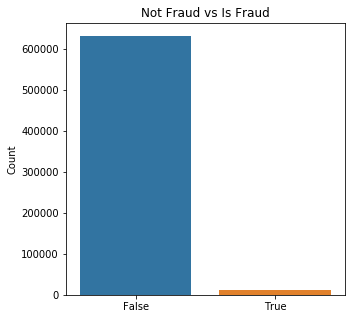

In [20]:
target_info(data_df['isFraud'])

### The population distribution of Fraud cases is 1.76%.
* It indicates an extermely unbalanced fraud data
* We need to use this distribution to analyze each column to see if this column itself contains some information

**1. acqCountry** -- used in training
- There are 0.61% (< 2%) acqCountry data has empty values.
- The propotion of Fraud cases (3.48%) inside the empty acqCountry data are much greather than the population porpotion (1.76%)
- The number of empty string value ('') is even higher than 'MEX', 'CAN', and 'PR'
- The empty data of acqCountry has some information, we can't drop these data

In [33]:
categorical_info(data_df['acqCountry'])

The number of unique values: 5
Categories:
US     632303
         3913
MEX      2626
CAN      1870
PR       1202
Name: acqCountry, dtype: int64


There are total 3913 transactions in our data.
Is Fraud:
Count: 136
Proportion: 3.4799999999999995%
Not Fraud:
Count: 3777
Proportion: 96.52%


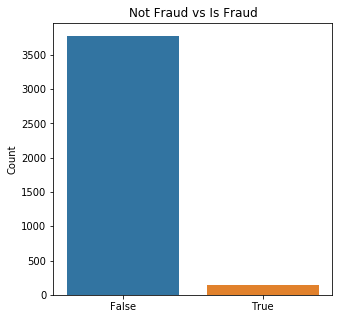

In [34]:
target_info(data_df[(data_df.acqCountry == '')]['isFraud'])

**2. merchantCountryCode** -- used in training
- There are 0.1% (< 2%) merchantCountryCode data has empty values.
- The propotion of Fraud cases (12.98%) inside the empty merchantCountryCode data are extremely greather than the population porpotion (1.76%)
- The missing data of merchantCountryCode has valuable information, we can't drop these data

In [35]:
categorical_info(data_df['merchantCountryCode'])

The number of unique values: 5
Categories:
US     635577
MEX      2636
CAN      1874
PR       1203
          624
Name: merchantCountryCode, dtype: int64


There are total 624 transactions in our data.
Is Fraud:
Count: 81
Proportion: 12.98%
Not Fraud:
Count: 543
Proportion: 87.02%


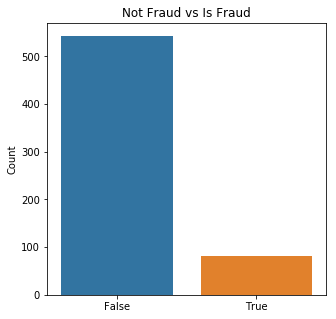

In [36]:
target_info(data_df[(data_df.merchantCountryCode == '')]['isFraud'])

**3. posConditionCode** -- used in training
- There are 0.04% (< 2%) posConditionCode data has empty values
- The porpotion of Fraud cases (4.53%) inside the empty posConditionCode data are  greather than the population porpotion (1.76%)
- The empty data of posConditionCode has some information, we can't drop these data

In [37]:
categorical_info(data_df['posConditionCode'])

The number of unique values: 4
Categories:
01    514144
08    121507
99      5976
         287
Name: posConditionCode, dtype: int64


There are total 287 transactions in our data.
Is Fraud:
Count: 13
Proportion: 4.53%
Not Fraud:
Count: 274
Proportion: 95.47%


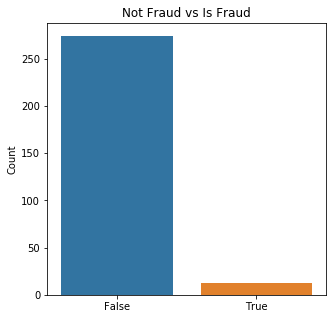

In [38]:
target_info(data_df[(data_df.posConditionCode == '')]['isFraud'])

**4. posEntryMode** -- used in training
- There are 0.52% (< 2%) posEntryMode data has empty values.
- The porpotion of Fraud cases (7.71%) inside the empty posEntryMode data are greather than the population porpotion (1.76%)
- The empty data of posEntryMode has some information, we can't drop these data


In [39]:
categorical_info(data_df['posEntryMode'])

The number of unique values: 6
Categories:
05    255615
09    193193
02    160589
90     16251
80     12921
        3345
Name: posEntryMode, dtype: int64


There are total 3345 transactions in our data.
Is Fraud:
Count: 258
Proportion: 7.71%
Not Fraud:
Count: 3087
Proportion: 92.29%


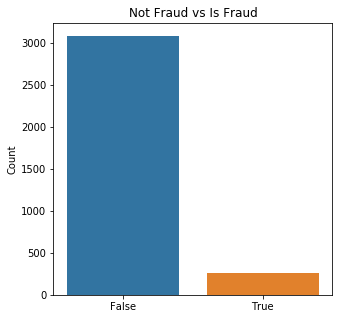

In [40]:
target_info(data_df[(data_df.posEntryMode == '')]['isFraud'])

**5. transactionType** -- used in training
- There are 0.09% (< 2%) transactionType data has empty values. 
- The porpotion of Fraud cases (2.04%) inside the empty posEntryMode data are greather than the population porpotion (1.76%)
- The empty data of posEntryMode has some information, we can't drop these data

In [41]:
categorical_info(data_df['transactionType'])

The number of unique values: 4
Categories:
PURCHASE                608685
ADDRESS_VERIFICATION     16478
REVERSAL                 16162
                           589
Name: transactionType, dtype: int64


There are total 8068 transactions in our data.
Is Fraud:
Count: 410
Proportion: 5.08%
Not Fraud:
Count: 7658
Proportion: 94.92%


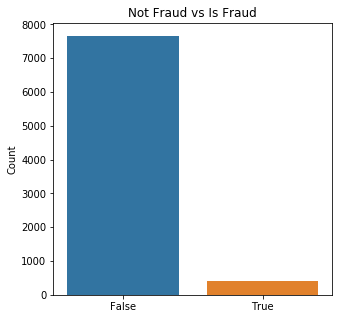

In [42]:
#check if distribution of missing_data's label is the same as the total dataset.
missing_data = data_df[(data_df.acqCountry == '') | 
                       (data_df.merchantCountryCode == '') |
                       (data_df.posConditionCode == '') |
                       (data_df.posEntryMode == '') |
                       (data_df.transactionType == '')]
target_info(missing_data.isFraud)

Let's think more about transactionType: 
- 'PURCHASE' means that credit card holders are paying money
- 'REVERSAL' means that merchants are returning money back to credit card holders

Thus, it indicates two different directs for transaction.
Let's combine transactionType and transactionAmount, see if we can find some patterns.

In [43]:
data_df[data_df['transactionType'] == 'PURCHASE']['transactionAmount'].describe()

count    608685.000000
mean        138.715258
std         147.307851
min           0.000000
25%          35.710000
50%          89.590000
75%         192.810000
max        1825.250000
Name: transactionAmount, dtype: float64

In [44]:
data_df[data_df['transactionType'] == 'REVERSAL']['transactionAmount'].describe()

count    16162.000000
mean       138.777076
std        147.747028
min          0.000000
25%         34.282500
50%         91.280000
75%        194.825000
max       1389.090000
Name: transactionAmount, dtype: float64

In [45]:
data_df[data_df['transactionType'] == 'ADDRESS_VERIFICATION']['transactionAmount'].describe()

count    16478.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: transactionAmount, dtype: float64

We can find that all transactionAmount for 'PURCHASE' and 'REVERSAL' are positive and all transactionAmount for 'ADDRESS_VERIFICATION' is zero. If 'PURCHASE' and 'REVERSAL' directs for transaction, one transactionAmount should be positive and one transactionAmount should be negative, but here are all positive. 
We may use transactionAmount and availableMoney to find the direction here, then based on the directions, we can impute missing values for transactionType.

Define 'PURCHASE' has a negative value, because users are paying some money, and 'REVERSAL' has positive value.

In [46]:
# fortunately, when transactionType is missing, no transactionAmount is 0,
# which means that every missing transactionType should be either 'PURCHASE' or 'REVERSAL'.
sum(data_df[data_df['transactionType'] == '']['transactionAmount'] == 0)

0

In [47]:
def direction_detection(df): 
    '''
    Identity direction for each transaction 
    Input: dataframe group by accountNumber
    '''
    direction = np.sign(df['availableMoney'][1:].values - df['availableMoney'][:-1].values)
    df['direction'] = [*list(direction), *[np.nan]]
    direction = df[['direction']]
    
    return direction

In [48]:
def transactionType_match(direction):
    '''
    Identity transactionType for each transaction 
    Input: float - direction for each transaction
    '''
    if direction == float(-1):
        return 'PURCHASE'
    elif direction == float(1):
        return 'REVERSAL'
    else:
        return ''

In [49]:
data_df['direction'] = data_df.groupby('accountNumber').apply(direction_detection)
data_df['transactionType'] = data_df.apply(lambda x: transactionType_match(x['direction']) 
                                           if x['transactionType'] == '' else x['transactionType'],
                                           axis = 1)

In [50]:
# there are still 6 transactionType missing
# probably becasue the 6 transactions are the last transaction in one accoutNumber
# so we are unable to calculate the direction
data_df[data_df['transactionType'] == '']

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,isFraud,currentBalance,cardPresent,expirationDateKeyInMatch,direction
26533,850576303,850576303,20000.0,19728.62,2016-11-29T13:19:20,99.98,Dinosaur Sandwitch Bar #160554,US,US,05,...,2012-07-31,512,512,6763,,False,271.38,True,False,NaN
53866,763201731,763201731,2500.0,1013.04,2016-12-30T13:00:02,46.91,gap.com,US,US,02,...,2016-12-02,348,348,4161,,False,1486.96,False,False,NaN
150289,357581317,357581317,5000.0,614.77,2016-12-29T11:06:32,31.83,Renaissance Hotel #825471,US,US,05,...,2014-05-05,260,260,5203,,False,4385.23,True,False,NaN
219589,630199357,630199357,7500.0,6360.32,2016-12-28T22:39:06,87.15,discount.com,US,US,02,...,2015-10-30,793,793,7400,,False,1139.68,False,False,NaN
265070,881835195,881835195,10000.0,10000.00,2016-12-20T11:49:38,407.13,Lyft,US,US,09,...,2015-02-17,402,402,672,,False,0.00,False,False,NaN
625537,456958366,456958366,7500.0,4350.81,2016-12-28T09:49:14,265.52,EZ Putt Putt #551896,US,US,09,...,2014-09-05,601,601,366,,False,3149.19,True,False,NaN


In [52]:
# all six transactions are not fraud
# these six transactions can be dropped
# because the number of missing sample is too small and it will affect other missing values
missing_transactionType = data_df[(data_df.transactionType == '')]

print(missing_transactionType[['acqCountry', 'merchantCountryCode', 'posConditionCode', 'posEntryMode']])
data_df = data_df.drop(data_df[data_df.transactionType == ''].index)


Empty DataFrame
Columns: [acqCountry, merchantCountryCode, posConditionCode, posEntryMode]
Index: []


**6. accountNumber** -- not used for training, because it is ID.

In [54]:
print('The number of unique accountNumber: {}'.format(len(data_df['accountNumber'].unique()))) 

The number of unique accountNumber: 5000


In [55]:
data_df['accountNumber'].value_counts()[:10] 

318001076    10034
456044564     8382
812328116     5494
838085703     5129
239875038     4705
877017103     4435
278064853     4227
353215513     3756
314506271     3410
917216469     3258
Name: accountNumber, dtype: int64

**7. accountOpenDate** -- not used for training. I am not sure if this feature is useful for now, but if we separate year-month-day, then use one-hot encoding to encode this feature. The dimension for this feature is kind of large. Regarding on the  model complexity, I don't prefer to using this feature for now. If our model doesn't perform well, we can consider to use this feature and try to find the correlation between accountOpenDate and our target varible.

In [56]:
# The number of unique accountNumber is greater than The number of unique accountOpenDate
# means some cards are opened in the same day.
print('The number of unique accountOpenDate: {}'.format(len(data_df['accountOpenDate'].unique()))) 

The number of unique accountOpenDate: 1826


In [57]:
print(data_df['accountOpenDate'].value_counts()[:10]) # range is large
print(data_df['accountOpenDate'].value_counts()[-10:]) 

2015-12-11    10137
2012-10-05     8382
2011-05-20     5494
2015-09-24     5478
2015-03-12     5398
2013-08-24     4836
2014-01-31     4753
2015-06-15     4612
2013-07-04     3780
2014-09-18     3311
Name: accountOpenDate, dtype: int64
2008-12-01    4
2012-05-02    4
2012-08-21    3
2012-09-12    3
2006-11-25    3
2012-05-30    3
2006-03-22    3
2010-08-24    3
2008-01-30    2
2011-07-13    2
Name: accountOpenDate, dtype: int64


In [58]:
print(data_df[data_df['isFraud']==True]['accountOpenDate'].value_counts()[:10])
print(data_df[data_df['isFraud']==True]['accountOpenDate'].value_counts()[-10:])

2014-06-06    324
2015-12-11    291
2013-07-04    205
2013-05-23    143
2014-01-11    119
2012-10-05     95
2013-08-24     85
2014-01-31     82
2013-04-07     81
2010-06-09     76
Name: accountOpenDate, dtype: int64
2012-03-12    1
2011-11-29    1
2015-04-30    1
2014-03-22    1
2015-02-23    1
2013-10-15    1
2014-10-08    1
2009-03-29    1
2011-11-25    1
2010-11-07    1
Name: accountOpenDate, dtype: int64


There are total 85313 transactions in our data.
Is Fraud:
Count: 1816
Proportion: 2.13%
Not Fraud:
Count: 83497
Proportion: 97.87%


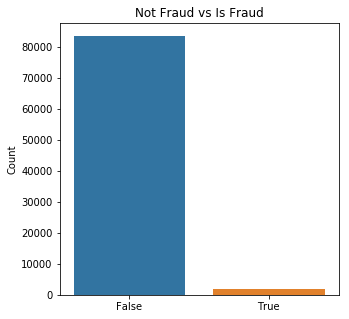

In [59]:
OpenDate_top_20 = list(data_df['accountOpenDate'].value_counts()[:20].index)
freq_OpenDate = data_df[data_df['accountOpenDate'].isin(OpenDate_top_20)]
target_info(freq_OpenDate.isFraud) # similar with whole data set distribution

**8. currentExpDate** -- not used in training. Based on common sense, this feature is usually not related with Fraud.

In [60]:
print('The number of unique currentExpDate: {}'.format(len(data_df['currentExpDate'].unique()))) 

The number of unique currentExpDate: 165


In [61]:
data_df['currentExpDate'].value_counts()[:10] # range relative small, compared with OpenDate

05/2026    4209
10/2019    4201
08/2020    4188
05/2028    4186
01/2025    4154
05/2024    4153
08/2028    4119
03/2024    4117
08/2018    4116
03/2019    4115
Name: currentExpDate, dtype: int64

In [62]:
data_df[data_df['isFraud']==True]['currentExpDate'].value_counts()[:10]

12/2021    95
08/2026    90
10/2024    89
11/2020    89
08/2025    86
10/2030    86
02/2029    85
12/2030    84
02/2031    83
11/2030    83
Name: currentExpDate, dtype: int64

**9. dateOfLastAddressChange** -- construct a new feature based on this. explained in new feature section

In [63]:
print('The number of unique dateOfLastAddressChange: {}'.format(len(data_df['dateOfLastAddressChange'].unique()))) 

The number of unique dateOfLastAddressChange: 2186


In [64]:
data_df['dateOfLastAddressChange'].value_counts()[:10]

2016-07-20    3948
2016-03-15    3800
2016-01-26    3140
2016-01-29    3033
2016-04-25    2954
2016-07-22    2943
2016-06-12    2810
2016-06-06    2672
2016-04-11    2638
2016-01-20    2599
Name: dateOfLastAddressChange, dtype: int64

In [65]:
def convert_AddressChange_time(time):
    time_fmt = '%Y-%m-%d'
    if isinstance(time, str):
        return datetime.datetime.strptime(time, time_fmt)
#     else:
#         return None

In [66]:
data_df['dateOfLastAddressChange'] = data_df.dateOfLastAddressChange.apply(lambda x: convert_AddressChange_time(x))

**10. expirationDateKeyInMatch** -- used in training. However, I am not sure what is variable's meaning. If it means, when people use credit card, whether the Expiration Date doesn't match or not. Why are the most of values False? Most of values should be true, because most of transactions are not Fraud.

If there is a documentation for explaining these variables' meaning, it will be very helpful.

In [67]:
print('The number of unique expirationDateKeyInMatch: {}'.format(len(data_df['expirationDateKeyInMatch'].unique()))) 

The number of unique expirationDateKeyInMatch: 2


In [68]:
data_df['expirationDateKeyInMatch'].value_counts() 

False    640939
True        969
Name: expirationDateKeyInMatch, dtype: int64

There are total 969 transactions in our data.
Is Fraud:
Count: 13
Proportion: 1.34%
Not Fraud:
Count: 956
Proportion: 98.66%


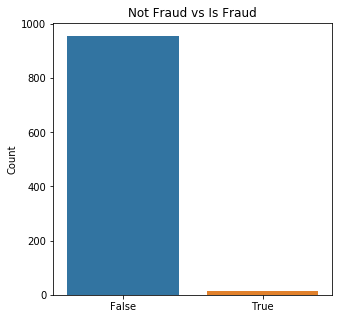

In [69]:
# when data_df.expirationDateKeyInMatch == True, the probability of Fraud is less.
target_info(data_df[(data_df.expirationDateKeyInMatch == True)]['isFraud'])

There are total 640939 transactions in our data.
Is Fraud:
Count: 11289
Proportion: 1.76%
Not Fraud:
Count: 629650
Proportion: 98.24000000000001%


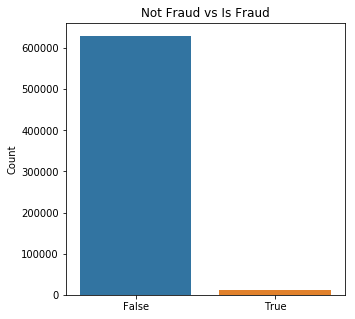

In [70]:
target_info(data_df[(data_df.expirationDateKeyInMatch == False)]['isFraud'])

**11. merchantCategoryCode ** -- used in training; Different merchantCategoryCodes have different chance to be a Fraud.

In [71]:
print('The number of unique merchantCategoryCode: {}'.format(len(data_df['merchantCategoryCode'].unique())))

The number of unique merchantCategoryCode: 19


In [72]:
data_df['merchantCategoryCode'].value_counts()

online_retail           161467
fastfood                101196
entertainment            69137
food                     68244
rideshare                50573
online_gifts             33045
hotels                   22878
fuel                     22566
subscriptions            18376
personal care            16917
mobileapps               14614
health                   14344
online_subscriptions     11247
auto                     10147
airline                   9990
furniture                 7813
food_delivery             4990
gym                       2874
cable/phone               1490
Name: merchantCategoryCode, dtype: int64

There are total 161467 transactions in our data.
Is Fraud:
Count: 3647
Proportion: 2.26%
Not Fraud:
Count: 157820
Proportion: 97.74000000000001%


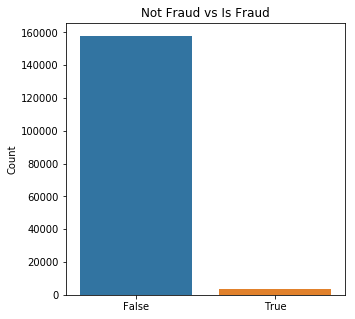

In [73]:
target_info(data_df[(data_df.merchantCategoryCode == 'online_retail')]['isFraud'])

There are total 22566 transactions in our data.
Is Fraud:
Count: 0
Proportion: 0.0%
Not Fraud:
Count: 22566
Proportion: 100.0%


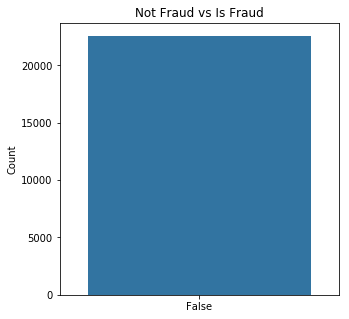

In [74]:
# when merchantCategoryCode == 'fuel', there is no Fraud.
target_info(data_df[(data_df.merchantCategoryCode == 'fuel')]['isFraud'])  

**12. merchantName ** -- used in training. Difference merchant has different fraud probability.

In [75]:
print('The number of unique merchantName: {}'.format(len(data_df['merchantName'].unique())))

The number of unique merchantName: 2493


In [76]:
data_df['merchantName'].value_counts()[:20] 

Lyft                             25310
Uber                             25263
gap.com                          13823
apple.com                        13607
target.com                       13601
alibaba.com                      13583
staples.com                      13512
amazon.com                       13477
ebay.com                         13472
discount.com                     13393
oldnavy.com                      13381
walmart.com                      13282
sears.com                        13279
cheapfast.com                    13057
Apple iTunes                      7579
Play Store                        7035
Mobile eCards                     4169
Blue Mountain eCards              4165
Blue Mountain Online Services     4149
Fresh eCards                      4147
Name: merchantName, dtype: int64

There are total 7579 transactions in our data.
Is Fraud:
Count: 0
Proportion: 0.0%
Not Fraud:
Count: 7579
Proportion: 100.0%


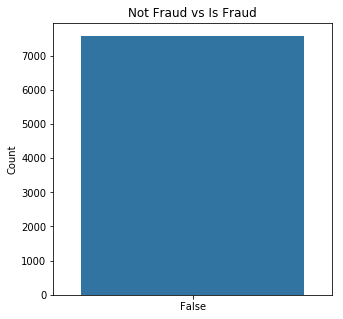

In [77]:
# there is no fruad for Apple iTunes.
target_info(data_df[(data_df.merchantName == 'Apple iTunes')]['isFraud'])

There are total 25263 transactions in our data.
Is Fraud:
Count: 575
Proportion: 2.2800000000000002%
Not Fraud:
Count: 24688
Proportion: 97.72%


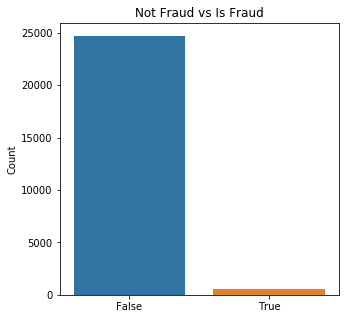

In [78]:
target_info(data_df[(data_df.merchantName == 'Uber')]['isFraud'])

#### From the three graph above, we can see depends on different merchantName, the Fruad proportion may be different. We are going to construct new features based on this.

**13. transactionDateTime** -- not used for training for now. Based on common sense,  but if we separate year-month-day, then use one-hot encoding to encode this feature. The dimension for this feature is kind of long. Regarding on the  model complexity, I don't prefer to using this feature for now. If our model doesn't perform well, we can consider to use this feature and try to find the correlation between accountOpenDate and our target varible.

In [79]:
print('The number of unique transactionDateTime: {}'.format(len(data_df['transactionDateTime'].unique())))

The number of unique transactionDateTime: 635466


In [80]:
data_df['transactionDateTime'].value_counts()[:10]

2016-07-30T11:22:18    3
2016-03-30T13:11:16    3
2016-06-14T22:02:40    3
2016-11-27T12:15:24    3
2016-06-15T22:46:39    3
2016-12-26T08:59:23    3
2016-01-07T09:56:55    3
2016-12-30T09:23:08    3
2016-06-13T06:30:14    3
2016-11-01T09:09:27    3
Name: transactionDateTime, dtype: int64

In [81]:
def convert_transaction_time(time):
    time_fmt = '%Y-%m-%dT%H:%M:%S'
    if isinstance(time, str):
        return datetime.datetime.strptime(time, time_fmt)
#     else:
#         return None

In [82]:
data_df['transactionDateTime'] = data_df.transactionDateTime.apply(lambda x: convert_transaction_time(x))
# separate day and time for future use
data_df['transaction_date'] = data_df.transactionDateTime.apply(lambda x: x.date()) # add date column
data_df['transaction_time'] = data_df.transactionDateTime.apply(lambda x: x.time()) # add time column

In [83]:
trans_date=data_df[data_df['isFraud']==True].groupby('transaction_date')['isFraud'].count()
trans_date=trans_date.reset_index()
trans_date_no_fraud=data_df[data_df['isFraud']==False].groupby('transaction_date')['isFraud'].count()
trans_date_no_fraud=trans_date_no_fraud.reset_index()
trans_date_no_fraud.columns=['transaction_date','notFraud']
trans_date_fraud=trans_date.merge(trans_date_no_fraud,on=['transaction_date'])

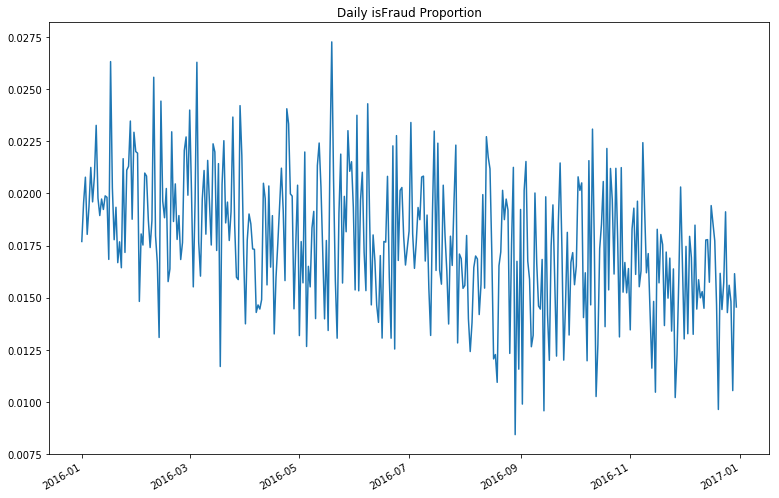

In [84]:
fig = plt.figure(figsize=(10,6))

ax1 = fig.add_axes([0,0,1,1])
ax1.plot(trans_date_fraud.transaction_date,
         trans_date_fraud.isFraud/(trans_date_fraud.isFraud+trans_date_fraud.notFraud))
#set_xaxis=ax1.set_xticklabels(labels=trans_date_fraud.transaction_date, rotation=45, ha='right')
plt.gcf().autofmt_xdate()

ax1.set_title('Daily isFraud Proportion')

We can see there is a potential pattern based on day in each month, so I contruct a new column using day.

In [85]:
# ignore year here, becasue all dates are in 2016
data_df['transaction_day'] = data_df.transactionDateTime.apply(lambda x: x.day)

**14. cardPresent ** -- used in training; When cardPresent is True, the Fraud probability is less 

In [86]:
print('The number of unique cardPresent: {}'.format(len(data_df['cardPresent'].unique())))

The number of unique cardPresent: 2


In [87]:
data_df['cardPresent'].value_counts()

False    340450
True     301458
Name: cardPresent, dtype: int64

When 'cardPresent' be True, the transaction tends to be a Fraud less. 

There are total 301458 transactions in our data.
Is Fraud:
Count: 4678
Proportion: 1.55%
Not Fraud:
Count: 296780
Proportion: 98.45%


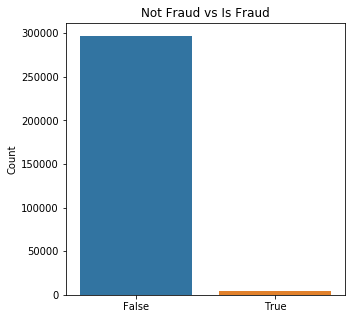

In [88]:
target_info(data_df[data_df['cardPresent'] == True].isFraud)

There are total 340450 transactions in our data.
Is Fraud:
Count: 6624
Proportion: 1.95%
Not Fraud:
Count: 333826
Proportion: 98.05%


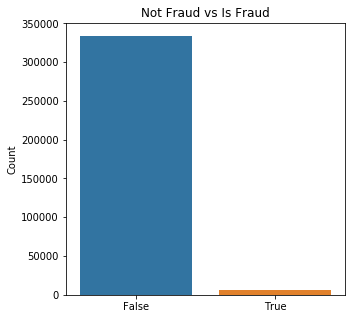

In [89]:
target_info(data_df[data_df['cardPresent'] == False].isFraud)

**15. customerId** -- not used in training. same as ID. 

In [90]:
print('The number of unique customerId : {}'.format(len(data_df['customerId'].unique())))

The number of unique customerId : 5000


In [91]:
data_df['customerId'].value_counts()[:10]

318001076    10034
456044564     8382
812328116     5494
838085703     5129
239875038     4705
877017103     4435
278064853     4227
353215513     3756
314506271     3410
917216469     3258
Name: customerId, dtype: int64

**16. cardCVV** -- not used in training. construct a new feature based on this. explained in new feature section

In [92]:
print('The number of unique cardCVV : {}'.format(len(data_df['cardCVV'].unique())))

The number of unique cardCVV : 899


In [93]:
data_df['cardCVV'].value_counts()[:10]

633    11354
746     8886
625     7626
312     6583
986     6464
676     5780
731     4979
180     4039
465     3869
654     3808
Name: cardCVV, dtype: int64

**17. cardLast4Digits** -- not used in training. Same as ID.

In [94]:
print('The number of unique cardLast4Digits : {}'.format(len(data_df['cardLast4Digits'].unique())))

The number of unique cardLast4Digits : 5134


In [95]:
data_df['cardLast4Digits'].value_counts()[:10]

1789    10034
5658     8412
0000     6727
5335     5542
4062     5146
4690     4435
7267     4227
2705     3766
2640     3414
6060     3046
Name: cardLast4Digits, dtype: int64

In [97]:
# same as the whole dataset distribution
# so not use this one in training
target_info(data_df[data_df['cardLast4Digits'] == 0].isFraud) 

There are total 0 transactions in our data.
Is Fraud:
Count: 0


ZeroDivisionError: division by zero

**18. enteredCVV** -- not used in training. construct a new feature based on this. explained in new feature section

In [98]:
print('The number of unique enteredCVV : {}'.format(len(data_df['enteredCVV'].unique())))

The number of unique enteredCVV : 980


In [99]:
data_df['enteredCVV'].value_counts()[:10]

633    11254
746     8816
625     7559
312     6524
986     6399
676     5745
731     4923
180     4007
465     3825
654     3775
Name: enteredCVV, dtype: int64

### **numerical variables**
***

In [100]:
def numerical_info(df_column):
    '''
    Plot numerical variable
    Input: str - numerical variable column name in dataframe
    '''
    sns.set(rc={'figure.figsize':(8, 6)})
    ax = sns.distplot(data_df[df_column], bins=50, kde=False)
    ax.set(xlabel=df_column, ylabel='frequency')

**1. availableMoney ** -- used in training

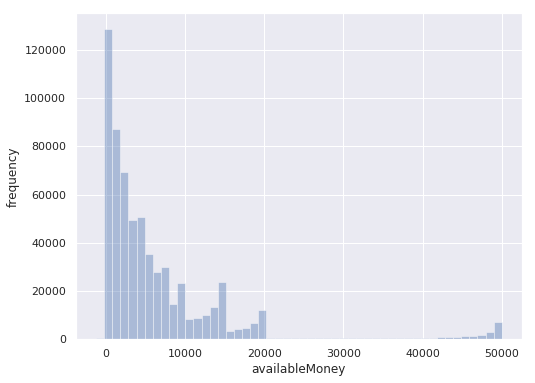

In [101]:
numerical_info('availableMoney')

**2. currentBalance ** -- used in training

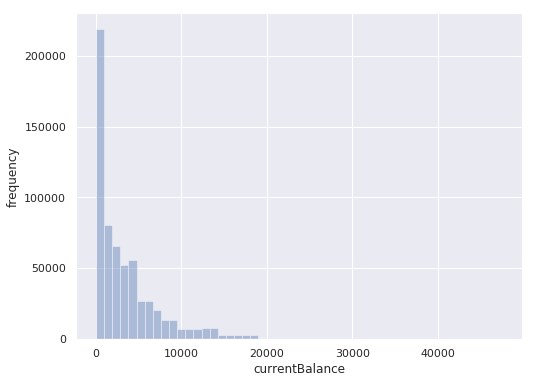

In [102]:
numerical_info('currentBalance')

**3. creditLimit ** -- used in training

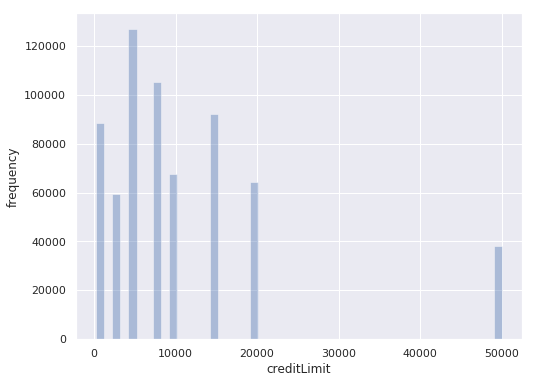

In [103]:
numerical_info('creditLimit')

**4. transactionAmount ** -- I will analyze this variable in detail in next question.
-- used in training

All numerical variables will be used in training. Because of common sense, these are all related if the transaction will be Fraud. While there are correlations between them, such as availableMoney and currentBalance, we will analyze these later, when we construct model.

### **new variables**
***

**1. Number of days between day_transaction_AddressChange and transactionDateTime**

In [104]:
data_df['day_transaction_AddressChange'] = data_df.\
    apply(lambda x: abs((x['transactionDateTime'] - x['dateOfLastAddressChange']).days), axis = 1)

In [105]:
data_df[data_df['isFraud'] == True]['day_transaction_AddressChange'].describe()

count    11302.000000
mean       484.119359
std        645.274228
min          0.000000
25%         51.000000
50%        204.500000
75%        671.750000
max       5785.000000
Name: day_transaction_AddressChange, dtype: float64

In [106]:
data_df[data_df['isFraud'] == False]['day_transaction_AddressChange'].describe()

count    630606.000000
mean        535.193457
std         678.656722
min           0.000000
25%          59.000000
50%         266.000000
75%         783.000000
max       11320.000000
Name: day_transaction_AddressChange, dtype: float64

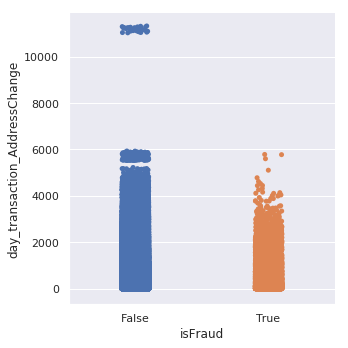

In [107]:
# we can see when the day_transaction_AddressChange value is large,
# the transaction tends not to be a Fraud. 
sns.catplot(x="isFraud", y="day_transaction_AddressChange", data=data_df);

**2. If cardCVV and enteredCVV are matched**
becasue if they are not matched, they probably are Fraud. 

In [108]:
data_df['matched_CVV'] = data_df.apply(lambda x: x['cardCVV'] == x['enteredCVV'], axis =1)
print('The number of unique matched_CVV : {}'.format(len(data_df['matched_CVV'].unique())))
print(data_df['matched_CVV'].value_counts())

The number of unique matched_CVV : 2
True     635971
False      5937
Name: matched_CVV, dtype: int64


There are total 635971 transactions in our data.
Is Fraud:
Count: 11107
Proportion: 1.7500000000000002%
Not Fraud:
Count: 624864
Proportion: 98.25%


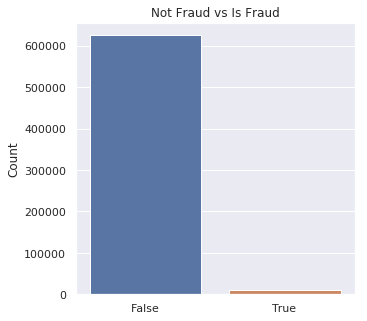

In [109]:
target_info(data_df[data_df['matched_CVV'] == True].isFraud)

There are total 5937 transactions in our data.
Is Fraud:
Count: 195
Proportion: 3.2800000000000002%
Not Fraud:
Count: 5742
Proportion: 96.72%


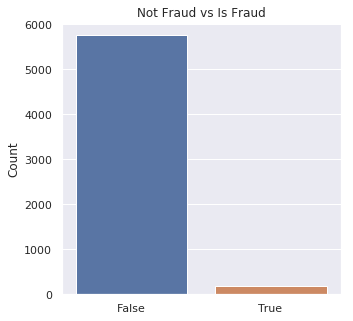

In [110]:
# we can see when the matched_CVV is False, the transaction tends not to be a Fraud. 
target_info(data_df[data_df['matched_CVV'] == False].isFraud) 

**3. accountNumber Fraud history**
- if the account has fraud in past seven days
- if the account has fraud in past seven month
- if the account has fraud in past 3-month

In [111]:
def create_feature_use_rolling_window(df, rolling_window):
    '''
    Calculate if the account has fraud before based on different rolling window
    Input: dataframe after group by, int - rolling_window
    '''
    
    date_fraud = list(df[df['isFraud'] == True]['transaction_date'])
    
    relative_date_fraud = [date + datetime.timedelta(days=i) for date in date_fraud for i in range(rolling_window)]
    relative_date_fraud = set(relative_date_fraud)
    
    df['rolling_window'] = df.apply(lambda x: 1 if x['transaction_date'] in relative_date_fraud else 0, axis = 1)
    
    return df[['rolling_window']]

In [112]:
data_df['rolling_window_7'] = data_df.groupby('accountNumber').\
                                      apply(create_feature_use_rolling_window, rolling_window = 7)

data_df['rolling_window_30'] = data_df.groupby('accountNumber').\
                                      apply(create_feature_use_rolling_window, rolling_window = 30)

data_df['rolling_window_90'] = data_df.groupby('accountNumber').\
                                      apply(create_feature_use_rolling_window, rolling_window = 90)

**4. merchantName Fraud history**
- if the merchant has fraud in past seven days
- if the merchant has fraud in past seven month
- if the merchant has fraud in past 3-month

In [113]:
data_df['merchant_rolling_window_7'] = data_df.groupby('merchantName').\
                                               apply(create_feature_use_rolling_window, rolling_window = 7)

data_df['merchant_rolling_window_30'] = data_df.groupby('merchantName').\
                                                apply(create_feature_use_rolling_window, rolling_window = 30)

data_df['merchant_rolling_window_90'] = data_df.groupby('merchantName').\
                                                apply(create_feature_use_rolling_window, rolling_window = 90)

In [114]:
data_df['transactionAmount'].describe()

count    641908.000000
mean        135.162298
std         147.053391
min           0.000000
25%          32.320000
50%          85.800000
75%         189.030000
max        1825.250000
Name: transactionAmount, dtype: float64

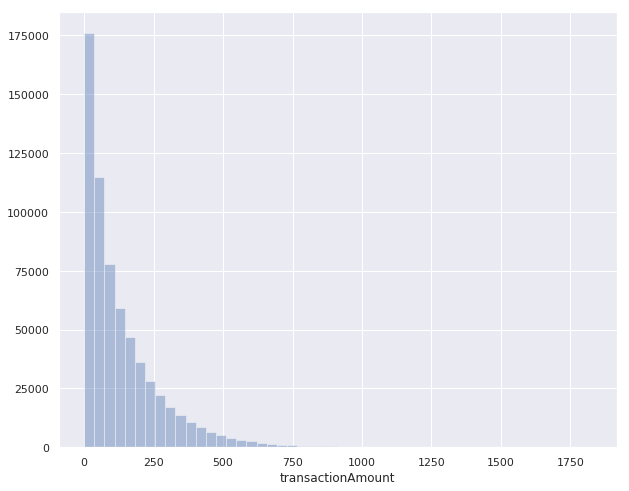

In [115]:
sns.set(rc={'figure.figsize':(10, 8)})
sns.distplot(data_df['transactionAmount'], bins=50, kde=False)

### exponential distribution 
- Firstly, the shape of histogarm of the transactionAmount lets me think about the exponential distribution naturally. Then I used a simulated exponential distribution draw a line on the histogram and it's perfectly matched.
- The transactionAmount is always greater than or equal to zero, same as the x in exponential distribution.
- People transact more frequent on small amount. When the amount become larger and larger, people tend to transact less. 
- Because exponentail distribution usually model occurence of events. For this dataset we use, the number of amount for each transactionAmount can be an event.

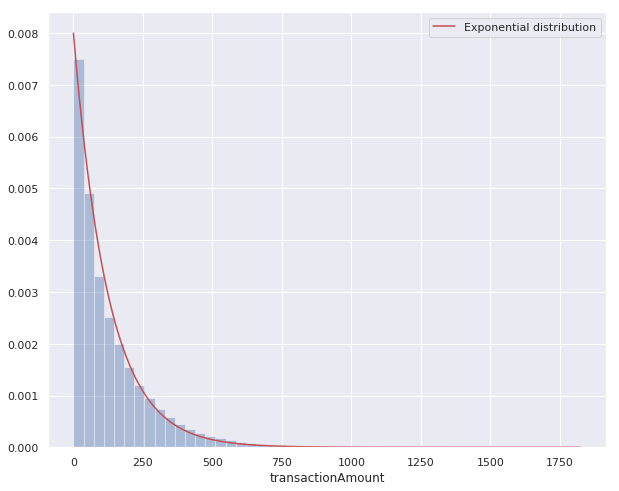

In [116]:
sns.set(rc={'figure.figsize':(10, 8)})
expo_lambda = 0.008

def simulate_expo_distribution(expo_lambda):
    '''
    Simulate exponential distribution
    Input: int - expo_lambda parameter for exponential distribution
    '''
    expo_dist = expo_lambda*np.exp(-expo_lambda*np.array(range(0, int(max(data_df['transactionAmount'])))))
    return expo_dist

expo_dist = simulate_expo_distribution(expo_lambda)
sns.distplot(data_df['transactionAmount'], bins=50, kde=False, norm_hist=True)
plt.plot(expo_dist,c = 'r',label = 'Exponential distribution')
plt.legend()

# Question 4:  Model
Fraud is a problem for any bank. Fraud can take many forms, whether it is someone stealing a single credit card, to large batches of stolen credit card numbers being used on the web, or even a mass compromise of credit card numbers stolen from a merchant via tools like credit card skimming devices.
## 1) Each of the transactions in the dataset has a field called isFraud. Please build a predictive model to determine whether a given transaction will be fraudulent or not. Use as much of the data as you like (or all of it).

### **Feature engineering**
***

### Besides adding new features, we need to transform categorical data into one-hot encoding and normalize numerical data

In [121]:
one_hot_en = ['acqCountry', 'merchantCountryCode', 'posConditionCode', 
              'posEntryMode', 'transactionType', 'expirationDateKeyInMatch', 
              'merchantCategoryCode', 'cardPresent']

In [122]:
def one_hot(df, one_hot_en_list):
    ''''''
    dummy_column_name = []
    for column_name in one_hot_en_list:
        dummy_col = pd.get_dummies(df[column_name])
        dummy_col.columns = [str(column_name) + '_' + str(name) for name in list(dummy_col.columns)]
        dummy_column_name.append(list(dummy_col.columns))
        df = df.join(dummy_col)
    return df, dummy_column_name

In [123]:
data_df, dummy_column_name = one_hot(data_df, one_hot_en)

In [124]:
data_df['matched_CVV'] =data_df['matched_CVV'].factorize(sort=True)[0]
data_df['rolling_window_7']=data_df['rolling_window_7'].factorize(sort=True)[0]
data_df['rolling_window_30']=data_df['rolling_window_30'].factorize(sort=True)[0]
data_df['rolling_window_90']=data_df['rolling_window_90'].factorize(sort=True)[0]
data_df['merchant_rolling_window_7']=data_df['merchant_rolling_window_7'].factorize(sort=True)[0]
data_df['merchant_rolling_window_30']=data_df['merchant_rolling_window_30'].factorize(sort=True)[0]
data_df['merchant_rolling_window_90']=data_df['merchant_rolling_window_90'].factorize(sort=True)[0]

In [125]:
dummy_column_name = [name for name_list in dummy_column_name for name in name_list]
features = ['availableMoney', 'creditLimit', 'currentBalance', 
            'transactionAmount', 'day_transaction_AddressChange'] # numerical features
features.extend(dummy_column_name)
print(len(features)) # total number of features

51


### is there any correlation between features?

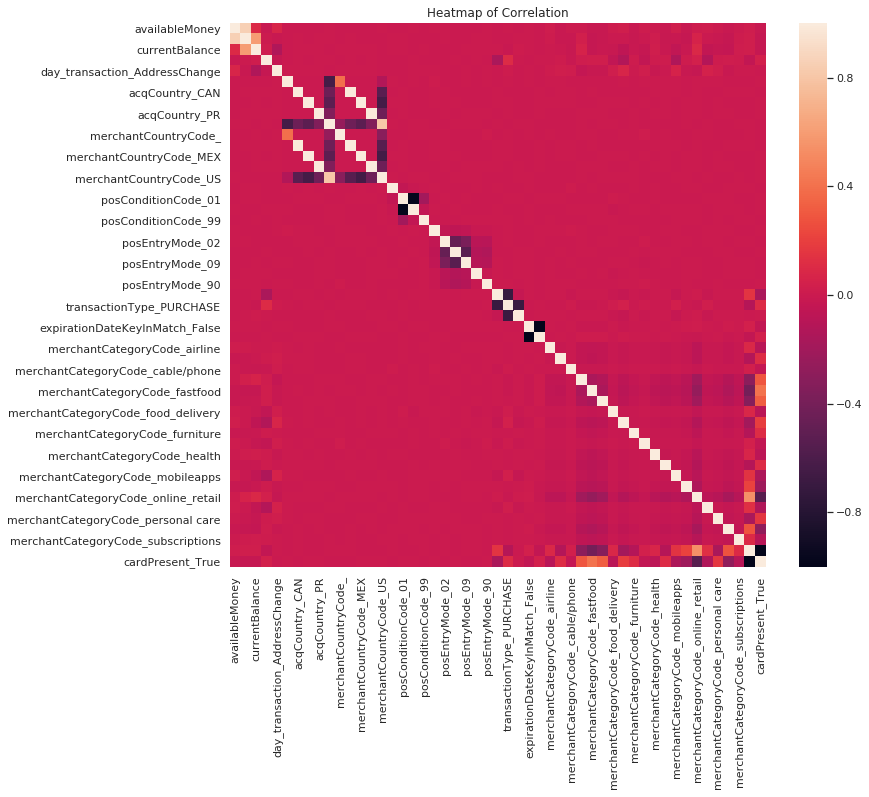

In [126]:
# Heatmap
corr = data_df[features].corr()
plt.figure(figsize=(12,10))
heat = sns.heatmap(data=corr)
plt.title('Heatmap of Correlation')
# although this heat map doesn't show all columns in features
# from the graph and our analysis, there are some correlations between the variables
# for now, I wouldn't process dimension reduction and feature selection due to the time limit
# If I have more time, I would like to finish this part.

#### Train - Test data split

In [127]:
data_model = data_df.copy()
data_model['isFraud'] = data_model['isFraud'].apply(lambda x: 1 if x == True else 0)
print(data_model.shape)

(641908, 82)


Because in reality, we can't use future data to predict if the current transaction is fraud, we split data by date. Otherwise, the training data information will be leaking into test data. Thus, if the date is before (2016,10, 1), then the data will be in train. If the date is after (2016,10, 1), then the data will be in test. Also, we need to check if the data distributions are the same as the population after spliting data 

In [128]:
data_df_before_10 =data_model[data_model['transaction_date']<datetime.date(2016,10, 1)]
data_df_after_10=data_model[data_model['transaction_date']>=datetime.date(2016,10, 1)]

In [129]:
X_train = data_df_before_10[features]
y_train = data_df_before_10['isFraud']

X_test = data_df_after_10[features]
y_test = data_df_after_10['isFraud']

There are total 170364 transactions in our data.
Is Fraud:
Count: 2781
Proportion: 1.63%
Not Fraud:
Count: 167583
Proportion: 98.37%


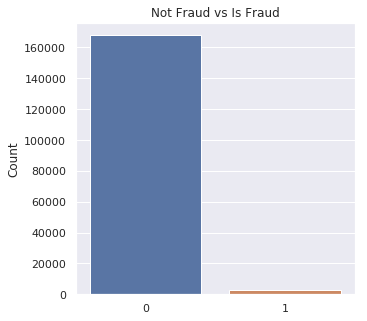

In [130]:
target_info(y_test) # proportion is same with the whole dataset/population

There are total 471544 transactions in our data.
Is Fraud:
Count: 8521
Proportion: 1.81%
Not Fraud:
Count: 463023
Proportion: 98.19%


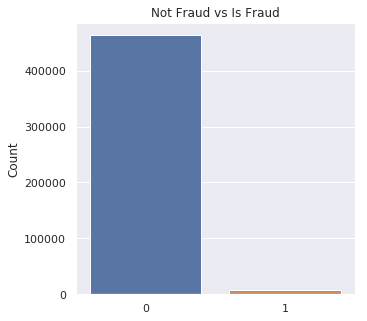

In [131]:
target_info(y_train) # we need to sample train dataset in order to having a balanced dataset.

### scale numeric data

In [132]:
numeric_features = ['availableMoney', 'creditLimit', 'currentBalance', 
                    'transactionAmount', 'day_transaction_AddressChange']

In [133]:
sc = StandardScaler()
X_train[numeric_features] = sc.fit_transform(X_train[numeric_features])
X_test[numeric_features] = sc.transform (X_test[numeric_features])

### **Random undersample imbalanced training data**
***

In [134]:
X_train_undersample = X_train.copy()

In [135]:
X_train_undersample = pd.DataFrame(X_train_undersample)
X_train_undersample['isFraud'] = y_train
Is_Fraud_df = X_train_undersample[X_train_undersample['isFraud'] == True]
Not_Fraud_df = X_train_undersample[X_train_undersample['isFraud'] == False]
print(Is_Fraud_df.shape)
print(Not_Fraud_df.shape)

(8521, 52)
(463023, 52)


In [136]:
Not_Fraud_df = Not_Fraud_df.sample(Is_Fraud_df.shape[0], random_state=0)
print(Not_Fraud_df.shape)

(8521, 52)


In [137]:
X_train_undersample = Is_Fraud_df.append(Not_Fraud_df)
X_train_undersample = shuffle(X_train_undersample)
print(X_train_undersample.shape)

(17042, 52)


(17042, 51)
(17042,)
There are total 17042 transactions in our data.
Is Fraud:
Count: 8521
Proportion: 50.0%
Not Fraud:
Count: 8521
Proportion: 50.0%


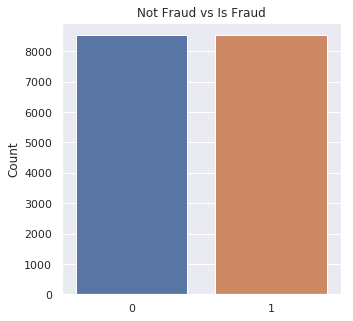

In [138]:
y_train_undersample = X_train_undersample['isFraud']
X_train_undersample = X_train_undersample.drop(columns = ['isFraud'])
print(X_train_undersample.shape)
print(y_train_undersample.shape)
target_info(y_train_undersample) # balance

### **Traditional machine learning**
***

In [156]:
class ML_models():
 
    def __init__(self, x_train, y_train, x_test, y_test, model, model_name, model_param):
        
        self.x_train = x_train          # x train
        self.y_train = y_train          # y train
        self.x_test = x_test            # x test
        self.y_test = y_test            # y test
        self.model = model              # model name in Python
        self.model_name = model_name    # model name save in models/
        self.model_param = model_param  # hyperparameter in model
        
    def train(self):
        '''train the model'''
        
        global model
        model = self.model + "()"
        model = eval(model)
        
        # use GridSearchCV tuning the hyperparameter
        model_grid = GridSearchCV(estimator = model, 
                                  param_grid = self.model_param, 
                                  scoring= 'f1', # using mean_squared_error if it is regression.
                                  n_jobs=4,
                                  cv=5)
        
        # record the start tuning time
        start_time_grid = time.time()
        print("Start training...")
        
        # start tuning model 
        model_grid.fit(self.x_train, self.y_train)
        
        # calculate total GridSearchCV time
        total_time_grid = time.time() - start_time_grid
        
        #print("The total GridSearchCV training time:", round(total_time_grid, 5))

        #print("The best hyperparameter:", model_grid.best_params_) 
        #print("The best score of GridSearchCV training:", round(model_grid.best_score_, 5))
        #print("<--------------------------------------->")
        
        # set the best tuning model parameter
        model.set_params(**model_grid.best_params_)
        
        # record the start train time
        start_time_train = time.time()
          
        # fit the model using the whole data set 
        model.fit(self.x_train, self.y_train)
        
        # save model
        dump(model, 'models/' + self.model_name + '.joblib') 
        
        # calculate the mean and std of the cv error
        model_score = cross_val_score(model, self.x_train, self.y_train,
                                      cv = 5, 
                                      # using mean_squared_error if it is regression. 
                                      scoring = 'accuracy')
        
        # calculate total re-train time
        time_retrain = time.time() - start_time_train
        
        print("The re-train time:", round(time_retrain, 5))
        print("The mean of CV score of the best training model:", round(model_score.mean(), 5))
        print("The std of CV score of the best training model:", round(model_score.std(), 5))
        
        return model_score.mean(), model_score.std(), model

    def train_SMOTE(self):
        
        global model
        model = self.model + "()"
        model = eval(model)
        
        # use GridSearchCV tuning the hyperparameter
        model_grid = RandomizedSearchCV(model, self.model_param, n_iter=5)

        SKFold = StratifiedKFold(n_splits = 5, random_state = 0, shuffle = False)

        # record the start tuning time
        start_time_grid = time.time()
        print("Start training...")
        fold_number = 1
        for train, test in SKFold.split(self.x_train, self.y_train):
            print('This is {} fold'.format(fold_number))
            fold_number += 1
            # Implementing SMOTE Technique 
            # SMOTE happens during Cross Validation not before..
            pipeline = imbalanced_make_pipeline(SMOTE(random_state = 0), model_grid) 
            model_grid = pipeline.fit(self.x_train, self.y_train)
        
        # calculate total GridSearchCV time
        end_time_grid = time.time() - start_time_grid
        #print("The total RandomizedSearchCV training time:", round(end_time_grid, 5))
        
        #print("The best hyperparameter:", model_grid.best_params_) 
        #print("The best score of RandomizedSearchCV training:", round(model_grid.best_score_, 5))
        print("<--------------------------------------->")
        
        # save model
        dump(model_grid, 'models/' + self.model_name + '.joblib')
        
        return model_grid
        
    def predict(self):
        '''predict the model'''
        
        start_time_prediction = time.time()
        global y_pred
        
        # predict use test data
        y_pred = model.predict(self.x_test)
        
        labels = ['No Fraud', 'Fraud']
        print(classification_report(self.y_test, y_pred, target_names=labels))
        
        total_time_prediction = time.time() - start_time_prediction        
        print("The total test time:", round(total_time_prediction, 5))
        
        return y_pred

### Baseline -- Logistic regression using undersample data

In [148]:
logistic_reg_params = {"penalty": ["l2"],                       # penalization
                       "C": [1, 2, 3],                          
                       # inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
                       "tol": [1e-4, 1e-5],                     # tolerance for stopping criteria
                       "solver": ["newton-cg", "lbfgs", "sag"], # only ‘newton-cg’, ‘sag’, and ‘lbfgs’ handle multinomial loss and only handle L2 penalty
                       "multi_class": ["multinomial"],          # here is multi-class
                       "random_state": [0]}

In [149]:
logistic_reg = ML_models(X_train_undersample, 
                         y_train_undersample, 
                         X_test, 
                         y_test, 
                         "LogisticRegression",
                         "logistic_reg_undersample",
                         model_param = logistic_reg_params)              

In [150]:
logistic_reg_train_undersample = logistic_reg.train()

Start training...
The total GridSearchCV training time: 24.08518
The best hyperparameter: {'C': 3, 'multi_class': 'multinomial', 'penalty': 'l2', 'random_state': 0, 'solver': 'newton-cg', 'tol': 0.0001}
The best score of GridSearchCV training: 0.68299
<--------------------------------------->
The re-train time: 3.87029
The mean of CV score of the best training model: 0.67398
The std of CV score of the best training model: 0.0045


### **SMOTE imbalanced training data**
***

In [151]:
print(X_train.shape)
print(y_train.shape)

(471544, 51)
(471544,)


In [157]:
logistic_reg_SMOTE = ML_models(X_train, 
                               y_train, 
                               X_test, 
                               y_test, 
                               "LogisticRegression",
                               "logistic_reg_SMOTE",
                               model_param = logistic_reg_params) 

In [158]:
logistic_reg_train_SMOTE = logistic_reg.train_SMOTE()

Start training...
This is 1 fold
This is 2 fold
This is 3 fold
This is 4 fold
This is 5 fold
The total RandomizedSearchCV training time: 46.15697


AttributeError: 'Pipeline' object has no attribute 'best_params_'

### Neural networks -- untuned -- Random undersample

In [173]:
def ANN_train(x, y):
    np.random.seed(0)
    input_dim = x.shape[1]
#     print(input_dim)
    
    batch_size = 100
    epochs = 20
    
    layer_1_hidden_unit = 30
    layer_1_activation = 'relu'
    layer_1_kernel_initializer = 'random_normal'
    
    layer_2_hidden_unit = 10
    layer_2_activation = 'relu'
    layer_2_kernel_initializer = 'random_normal'
    
    output_unit = 1
    output_activation = 'sigmoid'
    output_kernel_initializer = 'random_normal'
    
    optimizer = 'adam'
    loss = 'binary_crossentropy'
    
    # record the start tuning time
    start_time_grid = time.time()
    print("Start training...")
    
    ann = Sequential()
    #First Hidden Layer
    ann.add(Dense(layer_1_hidden_unit, activation = layer_1_activation, 
                  kernel_initializer = layer_1_kernel_initializer, input_dim = input_dim))
    #Second  Hidden Layer
    ann.add(Dense(layer_2_hidden_unit, activation = layer_2_activation, 
                  kernel_initializer = layer_2_kernel_initializer))
    #Output Layer
    ann.add(Dense(output_unit, activation = output_activation, 
                  kernel_initializer = output_kernel_initializer))
    # Complie Model
    ann.compile(optimizer = optimizer,loss = loss)
    # training
    ann_Result = ann.fit(x, y, batch_size = batch_size, epochs = epochs)
    
    # calculate total GridSearchCV time
    end_time_grid = time.time() - start_time_grid
    print("The total RandomizedSearchCV training time:", round(end_time_grid, 5))
    
    ann.save('models/ann.joblib')
    
    return ann, ann_Result

In [174]:
ann, ann_Result = ANN_train(X_train_undersample, y_train_undersample)

Start training...
Epoch 1/20
17042/17042 [==============================] - 0s 26us/step - loss: 0.6552
Epoch 2/20
17042/17042 [==============================] - 0s 13us/step - loss: 0.6076
Epoch 3/20
17042/17042 [==============================] - 0s 13us/step - loss: 0.5994
Epoch 4/20
17042/17042 [==============================] - 0s 13us/step - loss: 0.5945
Epoch 5/20
17042/17042 [==============================] - 0s 13us/step - loss: 0.5899
Epoch 6/20
17042/17042 [==============================] - 0s 13us/step - loss: 0.5870
Epoch 7/20
17042/17042 [==============================] - 0s 13us/step - loss: 0.5850
Epoch 8/20
17042/17042 [==============================] - 0s 12us/step - loss: 0.5826
Epoch 9/20
17042/17042 [==============================] - 0s 13us/step - loss: 0.5815
Epoch 10/20
17042/17042 [==============================] - 0s 12us/step - loss: 0.5800
Epoch 11/20
17042/17042 [==============================] - 0s 13us/step - loss: 0.5795
Epoch 12/20
17042/17042 [=========

In [165]:
loss_history = ann_Result.history["loss"] 
# if I have more time, I would like to plot a graph about loss to check if it is decreasing.

NameError: name 'ann_Result' is not defined

In [164]:
def ANN_predict(model, x_test):
    ann_predicted = model.predict_classes(X_test)
    return ann_predicted

## 2) Provide an estimate of performance using an appropriate sample, and show your work.

In [146]:
logistic_reg_predict_undersample = logistic_reg.predict()

              precision    recall  f1-score   support

    No Fraud       0.99      0.68      0.80    167583
       Fraud       0.03      0.70      0.07      2781

    accuracy                           0.68    170364
   macro avg       0.51      0.69      0.44    170364
weighted avg       0.98      0.68      0.79    170364

The total test time: 0.46228


In [147]:
# change logistic threshold to see if the test result can be better
# but this is not feasible in reality, because we can't know the test data label
test_y_score = logistic_reg_train_undersample[2].predict_proba(X_test)[:, 1]
test_y_preds = np.where(test_y_score>0.67, 1, 0)
print(classification_report(y_test, test_y_preds))

              precision    recall  f1-score   support

           0       0.99      0.91      0.95    167583
           1       0.06      0.33      0.10      2781

    accuracy                           0.90    170364
   macro avg       0.52      0.62      0.52    170364
weighted avg       0.97      0.90      0.93    170364



In [155]:
tn, fp, fn, tp = confusion_matrix(y_test, test_y_preds).ravel()


In [160]:
sum(test_y_preds==1)

15527

In [161]:
sum(y_test==1)

2781

In [156]:
tn

152963

In [157]:
tp

907

In [158]:
fp

14620

In [159]:
fn

1874

In [162]:
907/2781

0.32614167565623875

In [163]:
907/(14620+907)

0.058414374959747536

In [168]:
logistic_reg_predict_SMOTE = logistic_reg_SMOTE.predict()

             precision    recall  f1-score   support

   No Fraud       0.99      0.68      0.81    167583
      Fraud       0.03      0.71      0.07      2781

avg / total       0.98      0.68      0.79    170364

The total test time: 0.09302


In [178]:
ann_predicted = ann.predict_classes(X_test)
print(classification_report(y_test, ann_predicted))

             precision    recall  f1-score   support

          0       0.99      0.73      0.84    167583
          1       0.04      0.67      0.07      2781

avg / total       0.98      0.73      0.83    170364



In [181]:
test_y_score = ann.predict_proba(X_test)
test_y_preds = np.where(test_y_score>0.79, 1, 0)
print(classification_report(y_test, test_y_preds))

             precision    recall  f1-score   support

          0       0.99      0.97      0.98    167583
          1       0.08      0.15      0.10      2781

avg / total       0.97      0.96      0.96    170364



### Our goal is to detect every fraud which means that we don't missing any Fraud, so I think here recall is more important than other metric. Thus, I adjust the logistic regression threshold to see if it can increase the recall. As we can see f1 for fraud class increased from 0.07 to 0.1. However, this is not feasible in reality, because we can't know the test data label then to adjust the thresold. Overall, all models here didn't perform very well, because they have a low ability to detect Fraud.

## 3) Please explain your methodology (modeling algorithm/method used and why, what features/data you found useful, what questions you have, and what you would do next with more time)

### modeling algorithm/method used and why

#### Logistic Regression:

- Logistic regression is fast and effective, easy to implement, it is a good baseline model.
- Logistic regression outputs have a nice probabilistic interpretation, we can also tune the probability threshold to determine if we want to reduce more false postive or false negative
- Logisic regression is good at dealing with binary classification problem.

#### Neural Networks: 
- NNs have the ability to learn and model non-linear and complex relationships
- NNS can generalize, after learning from the initial inputs and their relationships, it can infer unseen relationships on unseen data as well, thus making the model generalize and predict on unseen data.
- NNs don't impose any restrictions on the input variables (like how they should be distributed).
- NNs can significantly outperform other models given lots of high quality labeled data.

### what features/data you found useful

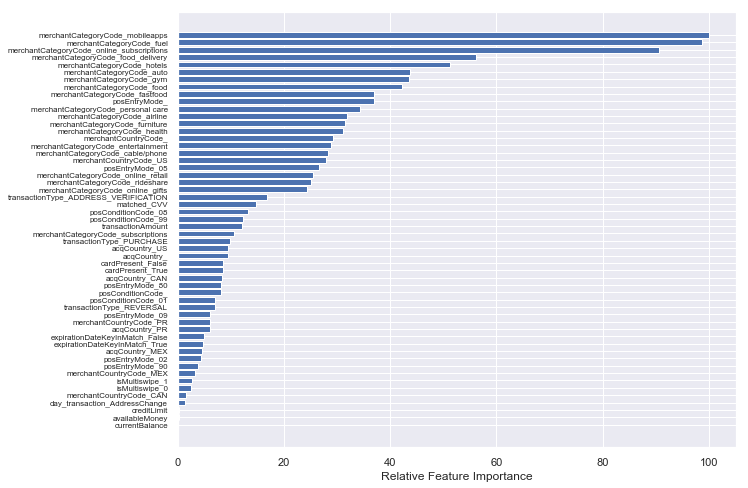

<Figure size 1440x1440 with 0 Axes>

In [193]:
feature_importance = abs(logistic_reg_train_undersample[2].coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5


featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X_train_undersample.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

- The top influential features are from merchantCategoryCode, which is consistent in our analysis for Question 1. Different merchantCategoryCode have different Fraud proportion.